In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

In [15]:
print("Loading data...")

train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

combined_df = pd.concat([train_df, test_df], ignore_index=True)

print("Removing rare classes...")

min_instances=5

category_counts = combined_df['category'].value_counts()
sub_category_counts = combined_df['sub_category'].value_counts()

valid_categories = category_counts[category_counts >= min_instances].index
filtered_df = combined_df[combined_df['category'].isin(valid_categories)].copy()

valid_sub_categories = sub_category_counts[sub_category_counts >= min_instances].index
filtered_df = filtered_df[filtered_df['sub_category'].isin(valid_sub_categories)].copy()

print("Number of removed categories:", len(category_counts) - len(valid_categories))
print("Number of removed sub categories:", len(sub_category_counts) - len(valid_sub_categories))
print("Instances removed:", len(combined_df) - len(filtered_df))

def clean_text(text):
    if pd.isna(text):
        return ''
    
    text = str(text).lower()
    
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    
    text = ' '.join(text.split())
    
    return text.strip()

print("Cleaning data...")

cleaned_df = filtered_df.copy()
cleaned_df.drop_duplicates(inplace=True)

cleaned_df['category'] = cleaned_df['category'].apply(clean_text)
cleaned_df['sub_category'] = cleaned_df['sub_category'].apply(clean_text)
cleaned_df['crimeaditionalinfo'] = cleaned_df['crimeaditionalinfo'].apply(clean_text)

cleaned_df.dropna(inplace=True)

print("Instances removed due to duplicates:", len(filtered_df) - len(cleaned_df))

Loading data...
Removing rare classes...
Number of removed categories: 2
Number of removed sub categories: 4
Instances removed: 8832
Cleaning data...
Instances removed due to duplicates: 7242


In [16]:
X = cleaned_df['crimeaditionalinfo']
y = cleaned_df[['category', 'sub_category']]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Text feature extraction
    ('clf', MultiOutputClassifier(RandomForestClassifier(random_state=42)))  # Multi-output classifier for both targets
])

In [19]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42)))])

In [20]:
y_pred = pipeline.predict(X_test)

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Separate the predictions into individual arrays for each target variable
y_pred_category, y_pred_sub_category = y_pred[:, 0], y_pred[:, 1]
y_test_category, y_test_sub_category = y_test['category'], y_test['sub_category']

# Calculate metrics for each target separately
metrics = {
    "Category": {
        "Accuracy": accuracy_score(y_test_category, y_pred_category),
        "Precision": precision_score(y_test_category, y_pred_category, average="macro"),
        "Recall": recall_score(y_test_category, y_pred_category, average="macro"),
        "F1 Score": f1_score(y_test_category, y_pred_category, average="macro"),
    },
    "Sub-category": {
        "Accuracy": accuracy_score(y_test_sub_category, y_pred_sub_category),
        "Precision": precision_score(y_test_sub_category, y_pred_sub_category, average="macro"),
        "Recall": recall_score(y_test_sub_category, y_pred_sub_category, average="macro"),
        "F1 Score": f1_score(y_test_sub_category, y_pred_sub_category, average="macro"),
    }
}

print("Category Metrics:")
for metric, value in metrics["Category"].items():
    print(f"{metric}: {value}")

print("\nSub-category Metrics:")
for metric, value in metrics["Sub-category"].items():
    print(f"{metric}: {value}")


/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/chiragagg5k/Desktop/Coding_Stuff/netra/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Category Metrics:
Accuracy: 0.7622306950250356
Precision: 0.5086114175603186
Recall: 0.2658120830352625
F1 Score: 0.27703095226621277

Sub-category Metrics:
Accuracy: 0.5146308971473196
Precision: 0.3686167152433256
Recall: 0.1583420853331787
F1 Score: 0.17326258743851236


In [31]:
from sklearn.metrics import classification_report

print("Category Classification Report:")
print(classification_report(y_test_category, y_pred_category, zero_division=0))

print("\nSub-category Classification Report:")
print(classification_report(y_test_sub_category, y_pred_sub_category, zero_division=0))

Category Classification Report:
                                               precision    recall  f1-score   support

                        any other cyber crime       0.76      0.06      0.11      2836
                         cryptocurrency crime       1.00      0.06      0.11       118
                cyber attack dependent crimes       1.00      1.00      1.00       972
                              cyber terrorism       0.00      0.00      0.00        51
hacking damage to computercomputer system etc       0.78      0.04      0.07       457
        online and social media related crime       0.80      0.51      0.62      3267
                     online cyber trafficking       0.00      0.00      0.00        45
                       online financial fraud       0.75      0.99      0.85     13888
                      online gambling betting       0.00      0.00      0.00       114
                                   ransomware       0.00      0.00      0.00        21

         

In [26]:
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

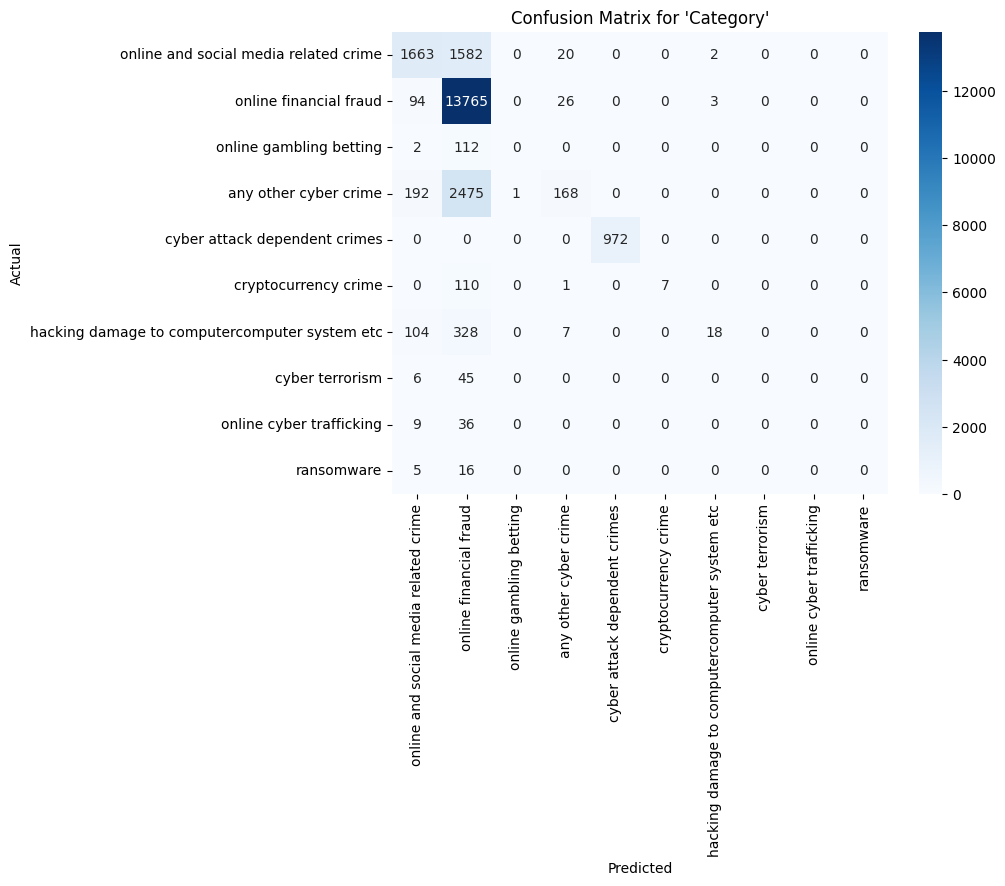

In [32]:
plot_confusion_matrix(y_test['category'], y_pred[:, 0], labels=y['category'].unique(), title="Confusion Matrix for 'Category'")

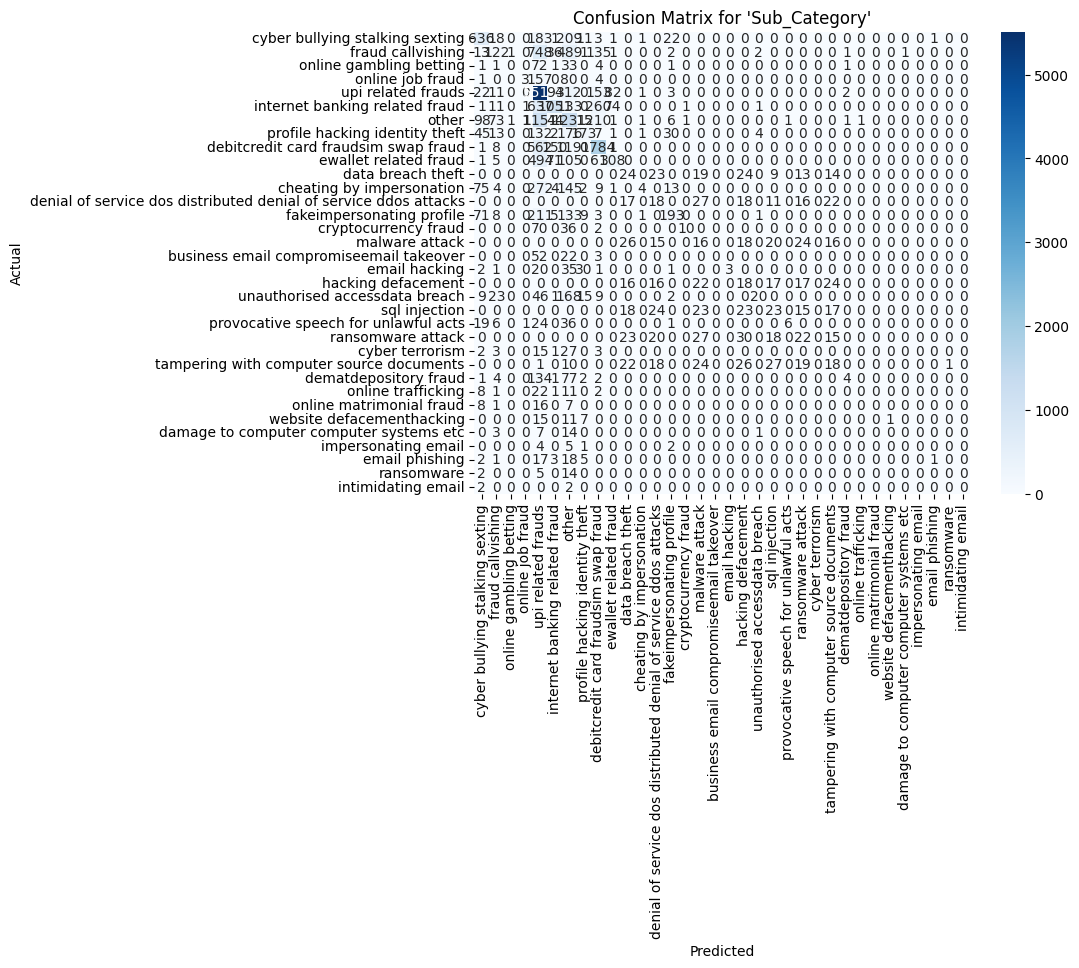

In [28]:
plot_confusion_matrix(y_test['sub_category'], y_pred[:, 1], labels=y['sub_category'].unique(), title="Confusion Matrix for 'Sub_Category'")

In [30]:
y_test_array = y_test.to_numpy()
y_pred_array = np.array(y_pred)

joint_accuracy = np.mean(np.all(y_test_array == y_pred_array, axis=1))

print(f"Joint Accuracy: {joint_accuracy}")


Joint Accuracy: 0.4627681565528963
